In [1]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,8)

# MNIST data

Now let's look at a slightly larger and more interesting dataset: the MNIST handwritten image dataset.

In [2]:
thin_by = 3
mnist_data = np.load('mnist.npz')
mnist_train_features = mnist_data['train'].T.astype(float)[::thin_by]
mnist_train_labels = mnist_data['train_labels'].flatten()[::thin_by]
mnist_test_features = mnist_data['test'].T.astype(float)[::thin_by]
mnist_test_labels = mnist_data['test_labels'].flatten()[::thin_by]

Our data is now in a $20,000 \times 784$ array. There are 20,000 examples, each being a 784-dimensional vector.

In [3]:
mnist_train_features.shape

(20000, 784)

In [4]:
mnist_train_features[0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,  51., 159., 253., 159.,  50.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

Each of these vectors is actually a 28x28 image, "flattened" into a vector. We can reshape and visualize it:

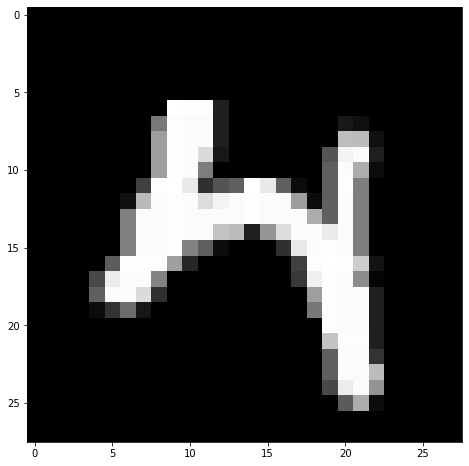

In [5]:
plt.imshow(mnist_train_features[10_000].reshape(28, -1), cmap='gray')

# Eigendigits

Images typically contain many correlated features, since nearby pixels behave similar to one another. We can apply PCA to find a basis in which the coordinates are decorrelated. First, we center the data:

In [6]:
X = mnist_train_features.T
mu = X.mean(axis=1)
X = X - mu[:,None]

We then compute the covariance:

In [7]:
C = X @ X.T / X.shape[1]

Next, we find the eigenvalues and eigenvectors of $C$:

In [8]:
eigvals, eigvecs = np.linalg.eigh(C)

# reorder eigenvalues/vectors from largest to smallest
eigvals = eigvals[::-1]
eigvecs = eigvecs[:,::-1]

Each image in the data set is a vector in $\mathbb R^{784}$, and each eigenvector of $C$ is a vector in the same space. As a result, we can visualize the eigenvectors in the same way:

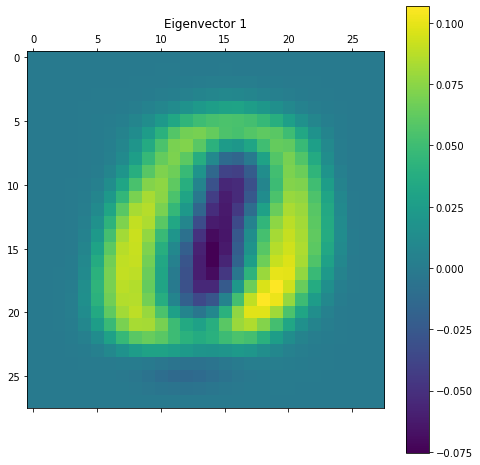

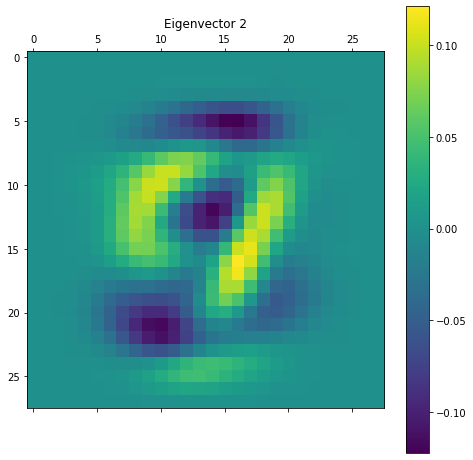

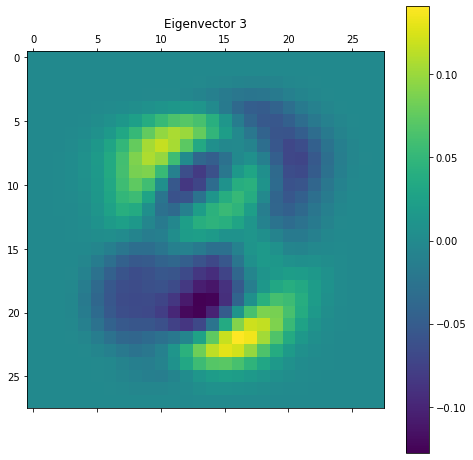

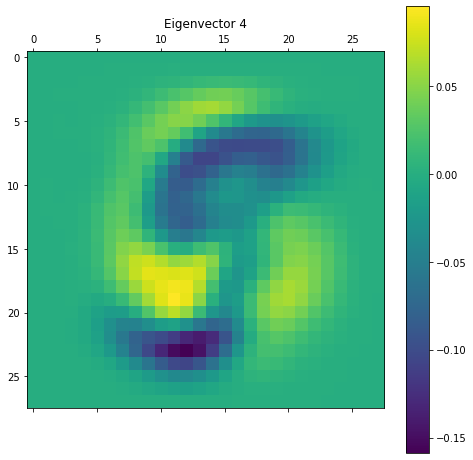

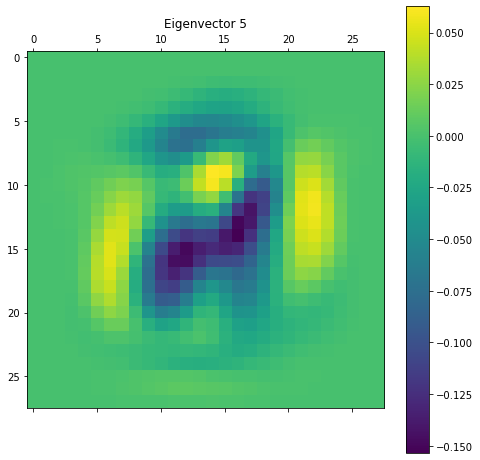

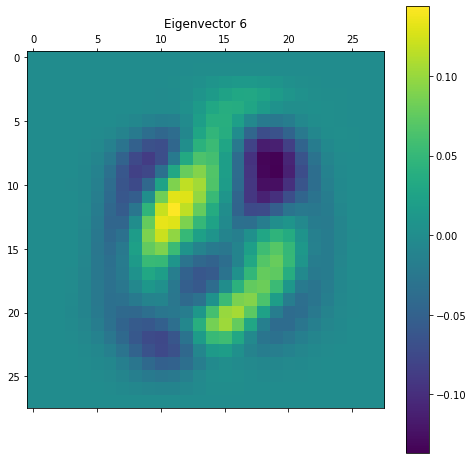

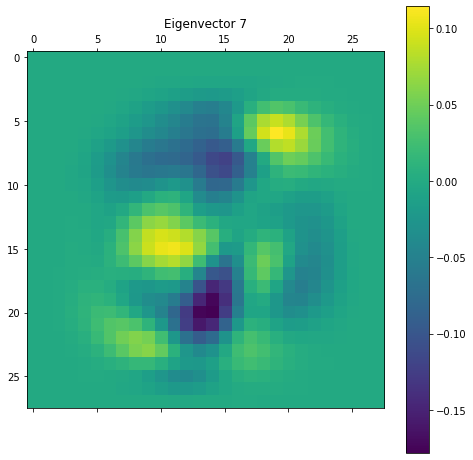

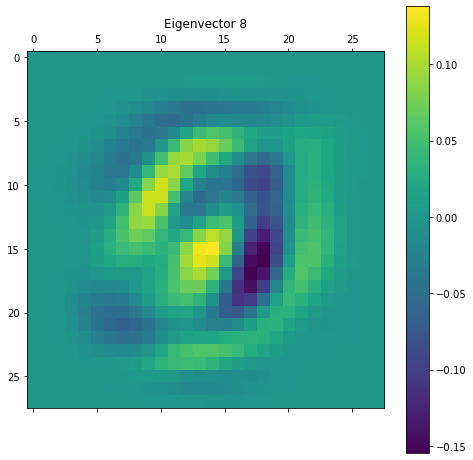

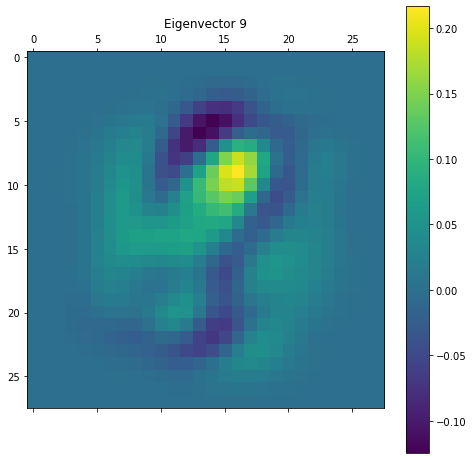

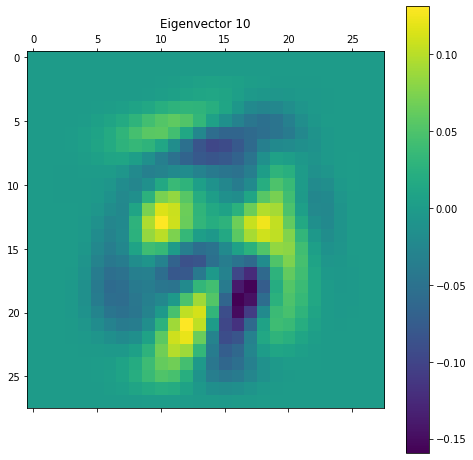

In [9]:
for i in range(10):
    plt.matshow(eigvecs[:,i].reshape(-1, 28))
    plt.title(f'Eigenvector {i+1}')
    plt.colorbar()

Any $28 \times 28$ image can be written as a linear combination of these eigenvectors. For instance, consider the image below:

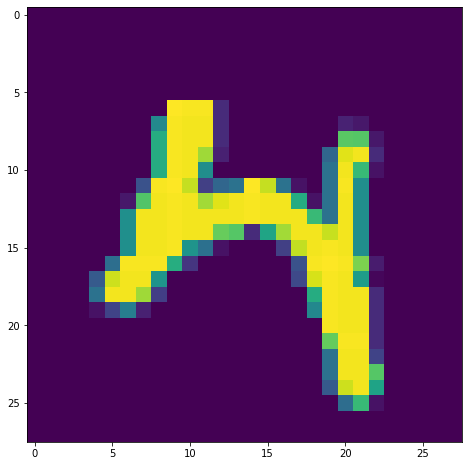

In [10]:
plt.imshow((mu + X[:,10_000]).reshape(-1, 28))

In [11]:
Q = eigvecs.T

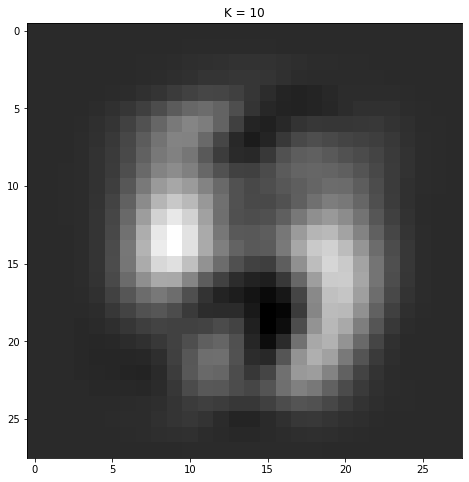

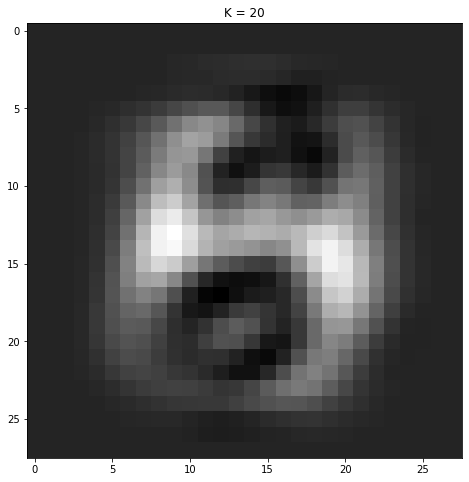

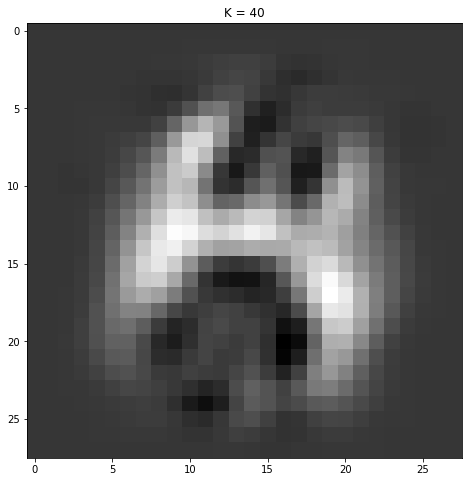

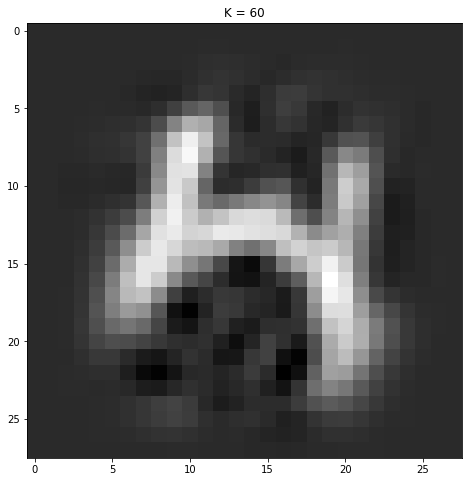

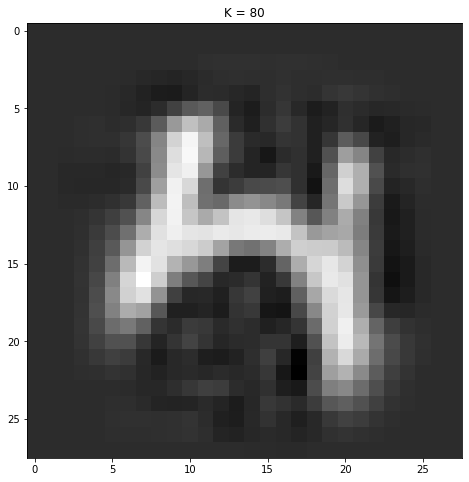

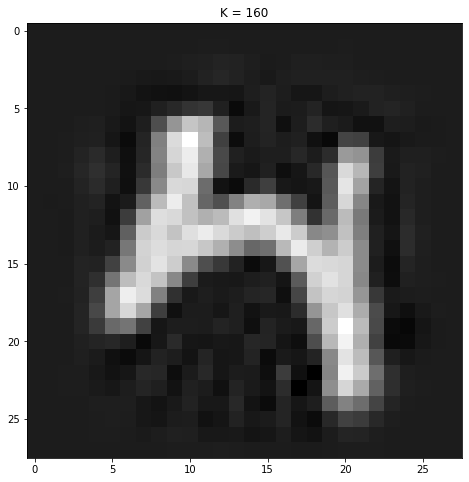

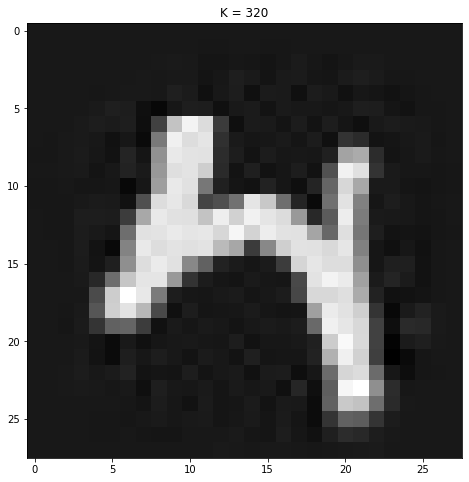

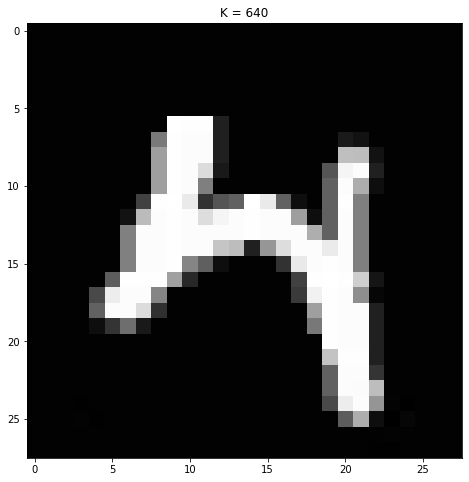

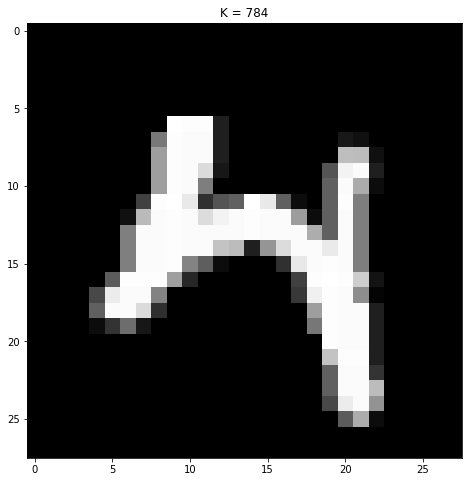

In [12]:
for K in [10, 20, 40, 60, 80, 160, 320, 640, 784]:
    P = Q[:K]
    z = P.T @ P @ X[:, 10_000] + mu
    
    plt.figure()
    plt.title(f'K = {K}')
    plt.imshow(z.reshape(-1, 28), cmap='gray')

But really, *any* $28 \times 28$ image can be decomposed like this:

In [13]:
img = plt.imread('bear.jpg').astype(float)

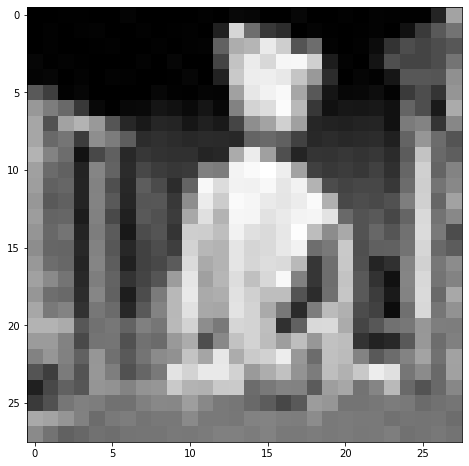

In [14]:
plt.imshow(img, cmap='gray')

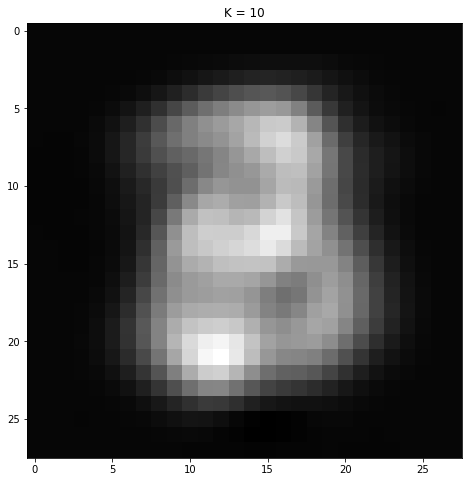

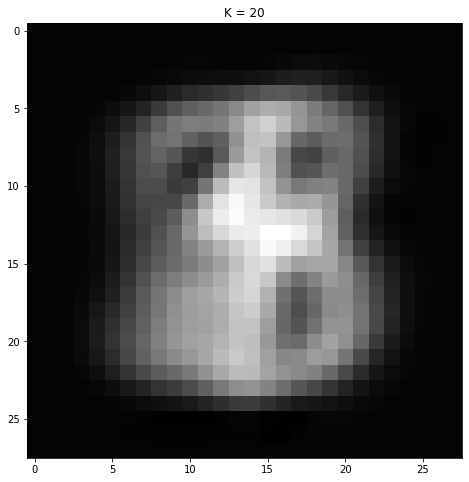

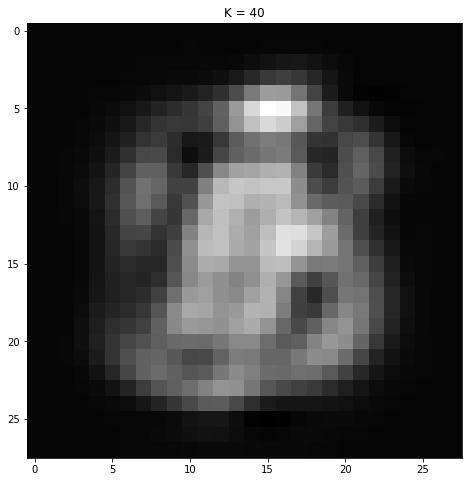

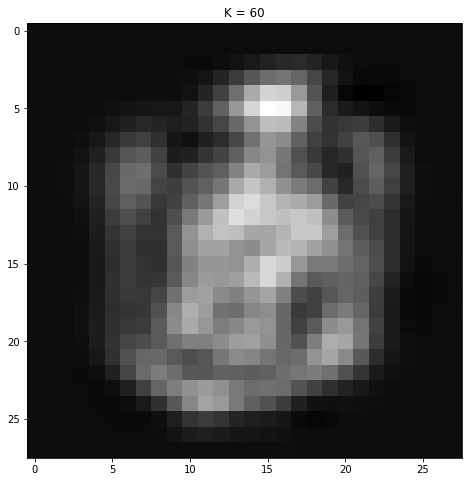

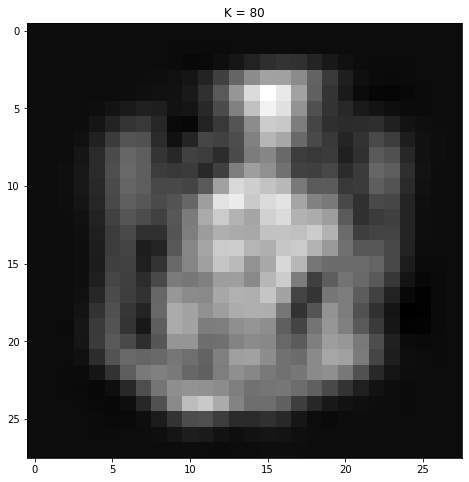

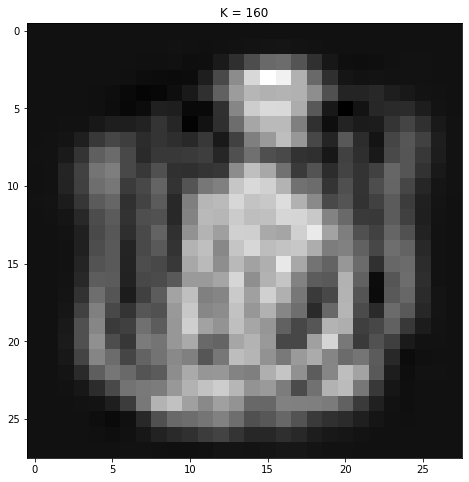

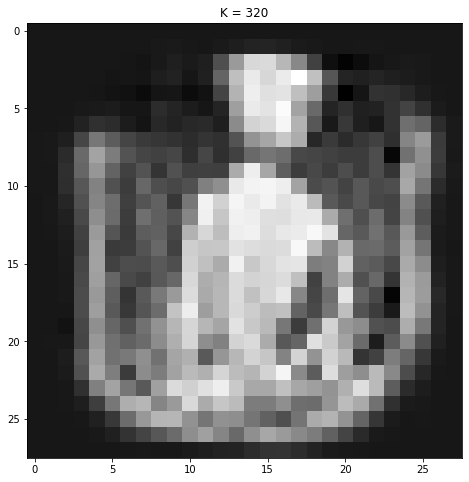

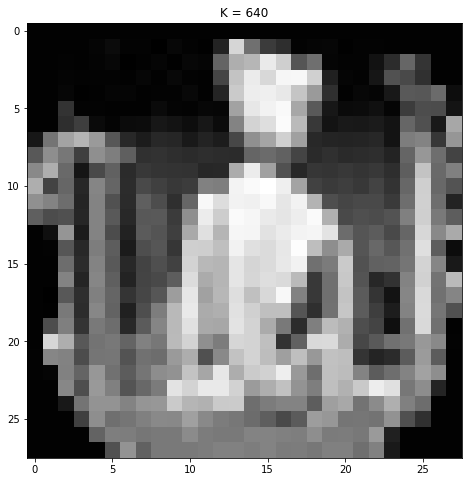

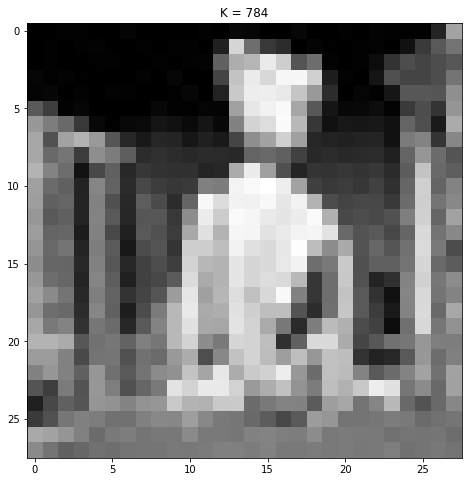

In [15]:
for K in [10, 20, 40, 60, 80, 160, 320, 640, 784]:
    P = Q[:K]
    z = P.T @ P @ (img.flatten() - mu) + mu
    
    plt.figure()
    plt.title(f'K = {K}')
    plt.imshow(z.reshape(-1, 28), cmap='gray')

# The kNN Classifier

First, we will test a kNN classifier on the original data set with no added noise.

In [16]:
import sklearn.neighbors

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=7)
knn.fit(mnist_train_features, mnist_train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [17]:
ix = np.random.choice(len(mnist_test_features), 200)
knn.score(mnist_test_features[ix], mnist_test_labels[ix])

0.935

We find that the classifier achieves about a 95% accuracy.

# Adding Noise

Now we will add many noisy dimensions to the data.

In [18]:
NUMBER_OF_NEW_ROWS = 28*3
NOISE_MU = 200
NOISE_SIGMA = 50

In [19]:
def add_noisy_dimensions(data):
    noisy_data = np.pad(data, [[0, 0], [0, NUMBER_OF_NEW_ROWS * 28]], 'constant')
    appended_shape = (noisy_data.shape[0], NUMBER_OF_NEW_ROWS*28)
    noisy_data += np.random.normal(NOISE_MU, NOISE_SIGMA, noisy_data.shape)
    return np.clip(noisy_data, 0, 255)

In [20]:
noisy_train_features = add_noisy_dimensions(mnist_train_features)
noisy_test_features = add_noisy_dimensions(mnist_test_features)

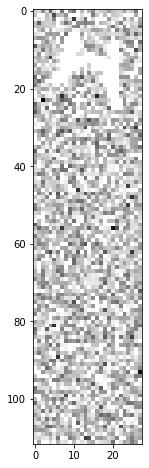

In [21]:
plt.imshow(noisy_train_features[10_000].reshape(-1, 28), cmap='gray')

How does the kNN classification performance suffer?

In [22]:
knn.fit(noisy_train_features, mnist_train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [23]:
ix = np.random.choice(len(mnist_test_features), 200)
knn.score(noisy_test_features[ix], mnist_test_labels[ix])

0.58

The new noisy dimensions have "confused" the classifier, and its accuracy is diminished.

# Dimensionality Reduction with PCA

Let's reduce the dimensionality with PCA. First, we center the data.

In [24]:
X_train = noisy_train_features.T
mu = X_train.mean(axis=1)
X_train = X_train - mu[:,None]

Now we compute the covariance matrix:

In [25]:
C = X_train @ X_train.T / X_train.shape[1]

Then we compute the eigenvalues and eigenvectors of $C$:

In [26]:
eigvals, eigvecs = np.linalg.eigh(C)

# reorder so that largest eigenvalues are first
eigvals = eigvals[::-1]
eigvecs = eigvecs[:,::-1]

We make the change of basis matrix, $Q$, whose rows are the eigenvectors of $C$. The coordinates of $\vec x$ in the new basis are given by $Q \vec x$.

In [27]:
Q = eigvecs.T

We will keep only $K$ eigenvectors with the greatest eigenvalues. But how do we choose $K$? One approach is the "elbow" method. Intuitively, the top eigenvectors capture useful variation while the bottom eigenvectors capture not-as-useful information (noise). The split between the "top" and "bottom" eigenvectors is usually not clearly defined, but we can make a good choice by plotting the eigenvalues and finding the point where they level out:

Text(0, 0.5, 'Eigenvalue')

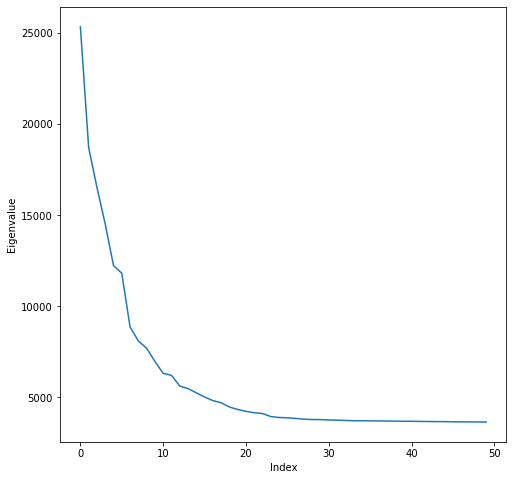

In [28]:
plt.plot(eigvals[:50])
plt.xlabel('Index')
plt.ylabel('Eigenvalue')

Let's keep the top 30:

In [29]:
P = Q[:30]

In [30]:
Z_train = P @ X_train

In [31]:
Z_train.shape

(30, 20000)

# Classification performance after dimensionality reduction

In [32]:
X_test = noisy_test_features.T - mu[:,None]
Z_test = P @ X_test

In [33]:
knn.fit(Z_train.T, mnist_train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [34]:
ix = np.random.choice(len(mnist_test_features), 1000)
knn.score(Z_test.T[ix], mnist_test_labels[ix])

0.895

We are close to where we were before the noise was added!